In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import StandardScaler



In [39]:
# Extract CSV
import zipfile

zip_file_path = "recipes_with_final_embeddings.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall() 

csv_file_path = "recipes_with_final_embeddings.csv"  
recipes_df = pd.read_csv(csv_file_path)

bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]


In [124]:
recipes_df = pd.read_csv("recipes_with_final_embeddings.csv")  
bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

from tensorflow.keras import regularizers

class CustomAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CustomAutoencoder, self).__init__()
        # Encoder
        self.input_noise = layers.GaussianNoise(0.05)  
        self.encoder_dense1 = layers.Dense(
            latent_dim, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_dense2 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_latent = layers.Dense(
            latent_dim, activation='relu',
            kernel_regularizer=regularizers.l1(1e-5)  
        )
        self.latent_noise = layers.GaussianNoise(0.05)
        self.latent_normalization = layers.LayerNormalization()

        # Decoder
        self.decoder_dense1 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_dense2 = layers.Dense(
            512, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.input_noise(inputs)  
        x = self.encoder_dense1(x)
        skip = x  # Skip connection
        x = self.encoder_dense2(x)
        latent = self.encoder_latent(x)
        latent = self.latent_noise(latent)  
        latent = self.latent_normalization(latent)  
        latent = layers.add([latent, skip])  

        # Decoder
        x = self.decoder_dense1(latent)
        x = self.decoder_dense2(x)
        reconstruction = self.decoder_output(x)
        return reconstruction, latent



input_dim = normalized_embeddings.shape[1]
latent_dim = 512  
custom_autoencoder = CustomAutoencoder(input_dim=input_dim, latent_dim=latent_dim)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [ ]:
def clustering_loss(latent_embeddings, lambda_cluster=1.0):
    mean_embedding = tf.reduce_mean(latent_embeddings, axis=0)
    distances = tf.norm(latent_embeddings - mean_embedding, axis=1)
    cluster_penalty = tf.reduce_mean(distances)
    return lambda_cluster * cluster_penalty

def combined_loss(y_true, y_pred, latent_embeddings, lambda_recon=1.0, lambda_cluster=0.5):
    recon_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    cluster_loss = clustering_loss(latent_embeddings, lambda_cluster)

    return lambda_recon * recon_loss + lambda_cluster * cluster_loss


In [157]:
@tf.function
def pretrain_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, _ = custom_autoencoder(x_batch)
        loss = tf.reduce_mean(tf.square(x_batch - y_pred))
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [158]:
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, latent = custom_autoencoder(x_batch)
        loss = combined_loss(x_batch, y_pred, latent)
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [ ]:
history = {'loss': [], 'silhouette': [], 'davies_bouldin': []}

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

pretrain_epochs = 5
fine_tune_epochs = 20
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_embeddings).batch(batch_size)

print("Starting Pretraining...")
for epoch in range(pretrain_epochs):
    print(f"Pretraining Epoch {epoch + 1}/{pretrain_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = pretrain_step(x_batch)  
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / (step + 1)
    print(f"Reconstruction Loss: {avg_loss:.4f}")

print("\nStarting Fine-tuning...")
for epoch in range(fine_tune_epochs):
    print(f"Fine-tuning Epoch {epoch + 1}/{fine_tune_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()

    latent_embeddings = custom_autoencoder(normalized_embeddings)[1].numpy()

    kmeans = KMeans(n_clusters=5, random_state=42).fit(latent_embeddings)
    silhouette = silhouette_score(latent_embeddings, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans.labels_)

    avg_loss = epoch_loss / (step + 1)
    history['loss'].append(avg_loss)
    history['silhouette'].append(silhouette)
    history['davies_bouldin'].append(davies_bouldin)

    print(f"Loss: {avg_loss:.4f}, Silhouette: {silhouette:.4f}, DB Index: {davies_bouldin:.4f}")


Starting Pretraining...
Pretraining Epoch 1/10
Reconstruction Loss: 0.8688
Pretraining Epoch 2/10
Reconstruction Loss: 0.7286
Pretraining Epoch 3/10
Reconstruction Loss: 0.6986
Pretraining Epoch 4/10
Reconstruction Loss: 0.6846
Pretraining Epoch 5/10
Reconstruction Loss: 0.6767
Pretraining Epoch 6/10
Reconstruction Loss: 0.6710
Pretraining Epoch 7/10
Reconstruction Loss: 0.6666
Pretraining Epoch 8/10
Reconstruction Loss: 0.6641
Pretraining Epoch 9/10
Reconstruction Loss: 0.6609
Pretraining Epoch 10/10
Reconstruction Loss: 0.6579

Starting Fine-tuning...
Fine-tuning Epoch 1/20
Loss: 2.5862, Silhouette: 0.1600, DB Index: 5.3699
Fine-tuning Epoch 2/20
Loss: 1.1745, Silhouette: 0.1164, DB Index: 2.7886
Fine-tuning Epoch 3/20
Loss: 1.0916, Silhouette: 0.3101, DB Index: 2.1889
Fine-tuning Epoch 4/20
Loss: 1.0633, Silhouette: 0.3717, DB Index: 1.3632
Fine-tuning Epoch 5/20
Loss: 1.0475, Silhouette: 0.4878, DB Index: 0.9643
Fine-tuning Epoch 6/20
Loss: 1.0361, Silhouette: 0.5578, DB Index: 1.3

In [ ]:
reconstructions, latent_embeddings = custom_autoencoder(normalized_embeddings)
reconstructions = reconstructions.numpy()
latent_embeddings = latent_embeddings.numpy()

assert bert_embeddings.shape == reconstructions.shape, "Shape mismatch between embeddings and reconstructions!"
mse = tf.reduce_mean(tf.square(bert_embeddings - reconstructions)).numpy()
print(f"Reconstruction MSE: {mse:.4f}")

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(latent_embeddings)

silhouette = silhouette_score(latent_embeddings, gmm_labels)
davies_bouldin = davies_bouldin_score(latent_embeddings, gmm_labels)
print(f"Silhouette Score (GMM): {silhouette:.4f}")
print(f"Davies-Bouldin Index (GMM): {davies_bouldin:.4f}")


Reconstruction MSE: 0.2920
Silhouette Score (GMM): 0.8568
Davies-Bouldin Index (GMM): 2.2139


In [ ]:
latent_var = np.var(latent_embeddings, axis=0)
print(f"Latent Embeddings Variance: {latent_var}")

if np.min(latent_var) < 1e-6:
    print("Warning: Some dimensions in latent embeddings have very low variance.")
else:
    print("Latent embeddings have sufficient variance.")
cosine_sim_matrix = cosine_similarity(latent_embeddings)

np.fill_diagonal(cosine_sim_matrix, np.nan)  
avg_cosine_similarity = np.nanmean(cosine_sim_matrix)

print(f"Average Pairwise Cosine Similarity: {avg_cosine_similarity:.4f}")

Latent Embeddings Variance: [2.85059059e-06 2.86075963e-09 4.42510695e-09 3.21760574e-09
 2.65386135e-09 2.92620173e-09 2.59679855e-09 3.18139959e-09
 4.10557366e-09 5.74459369e-09 6.52293579e-08 2.45462140e-08
 5.75679104e-09 6.10598872e-05 4.51320266e-05 4.65159156e-09
 5.24707477e-09 2.76209278e-09 3.75333808e-09 4.74308459e-09
 3.29118599e-09 9.17473130e-07 5.33196065e-09 5.26125943e-09
 2.66011881e-07 3.86484489e-09 1.44139193e-07 1.51595785e-07
 1.38354665e-07 7.55910719e-07 1.31428891e-07 1.24083897e-07
 2.87890778e-09 4.76219553e-09 5.58747359e-09 4.74081974e-09
 4.21373159e-09 4.53729765e-09 3.38373263e-09 4.01001587e-09
 6.27112895e-09 3.82734688e-09 4.51805704e-09 3.00578273e-09
 5.12791409e-09 4.43411530e-09 2.04903703e-08 4.99301267e-09
 3.11307558e-09 3.26308558e-09 2.84183144e-09 2.95614355e-09
 5.56341817e-09 2.74651057e-09 5.72555514e-09 4.40800196e-09
 3.29406924e-09 3.77277720e-09 6.36734709e-09 4.42274573e-09
 4.24573399e-09 4.71358526e-08 3.12649206e-07 3.87519972e

In [ ]:
from scipy.stats import entropy

kmeans_labels = KMeans(n_clusters=5, random_state=42).fit_predict(latent_embeddings)

cluster_sizes = np.bincount(kmeans_labels)
cluster_entropy = entropy(cluster_sizes)

print(f"Cluster Entropy: {cluster_entropy:.4f}")


Cluster Entropy: 0.1557


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python312\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


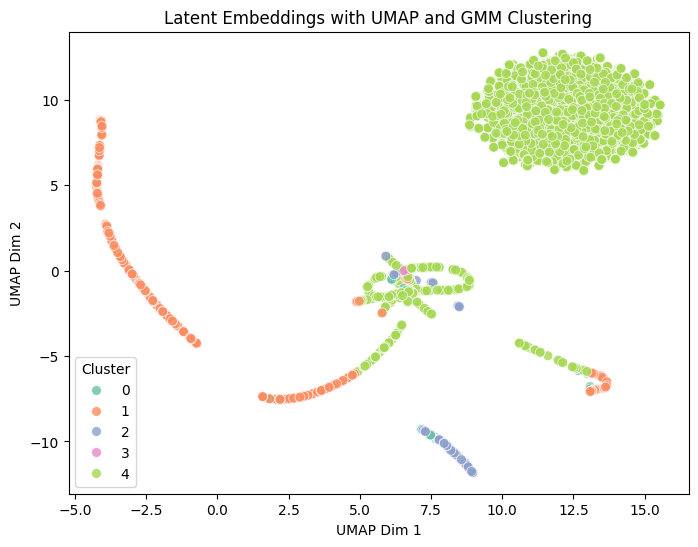

In [165]:
from umap import UMAP
import seaborn as sns
latent_umap = UMAP(n_components=2, random_state=42).fit_transform(latent_embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_umap[:, 0], y=latent_umap[:, 1], hue=gmm_labels, palette="Set2", s=50, alpha=0.8)
plt.title("Latent Embeddings with UMAP and GMM Clustering")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.show()


In [14]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [76]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Cheddar Chicken Tenders with Wilted Spinach,"['Food Processor', 'Chicken', 'Leafy Green', '...","['2 tablespoons olive oil', '1 1/2 cups Cheez-..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5):
  
    if not isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = latent_embeddings.numpy()

    liked_recipe_indices = [idx for idx in liked_recipe_indices if 0 <= idx < len(latent_embeddings)]
    if not liked_recipe_indices:
        raise ValueError("All indices in liked_recipe_indices are out of bounds.")

    print(f"Valid liked_recipe_indices: {liked_recipe_indices}")

    liked_embeddings = latent_embeddings[liked_recipe_indices]
    print(f"Liked Embeddings Shape: {liked_embeddings.shape}")

    similarity_scores = cosine_similarity(liked_embeddings, latent_embeddings)

    aggregated_scores = np.mean(similarity_scores, axis=0)

    recommended_indices = np.argsort(-aggregated_scores)
    recommended_indices = [idx for idx in recommended_indices if idx not in liked_recipe_indices][:top_n]

    return recommended_indices

In [ ]:
recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)

recommended_recipes_df = recipes_df.iloc[recommended_recipes][['title', 'categories', 'ingredients']]

display_liked_recipes(recommended_recipes_df)

Valid liked_recipe_indices: [76]
Liked Embeddings Shape: (1, 1024)
Liked Recipes:


,title,categories,ingredients
0,Caponatina Toasts,"['Olive', 'Bake', 'Sauté', 'Cocktail Party', '...",['18 (1/8-inch-thick) slices ficelle or baguet...
1,Brussels Sprouts with Golden Onion,"['Onion', 'Vegetable', 'Side', 'Vegetarian', '...",['10 ounces Brussels sprouts (about 2 1/2 cups...
2,Butternut Squash Galette,"['Food Processor', 'Bake', 'Dinner', 'Goat Che...","['1 1/4 cups all-purpose flour', '1 stick cold..."
3,Macadamia and Ginger Stuffing,"['Ginger', 'Side', 'Bake', 'Thanksgiving', 'St...",['6 cups 1/2- to 3/4-inch cubes Hawaiian bread...
4,"Castellane Pasta with Sausage, Peppers, Cherry...","['Herb', 'Onion', 'Pasta', 'Pepper', 'Pork', '...","['1 tablespoon extra-virgin olive oil', '1 pou..."
